## Imports

In [2]:
!dir

01lmo\ t1.ipynb   data_day_one	      data_day_two.csv	 README.md
01lmo\ t2.ipynb   data_day_one.csv    file_organizer.py  testscripts
02diw.ipynb	  data_day_three      func.py
03flour.ipynb	  data_day_three.csv  IMAGES
config_parser.py  data_day_two	      parameter.ipynb


In [3]:
# offizielle libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lmfit.models import Model
%matplotlib inline

In [4]:
# selbstgeschrieben
import file_organizer as fo
from func import get_norm_cm
from func import ticks_handle

## FID

In [5]:
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "J")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove('time')

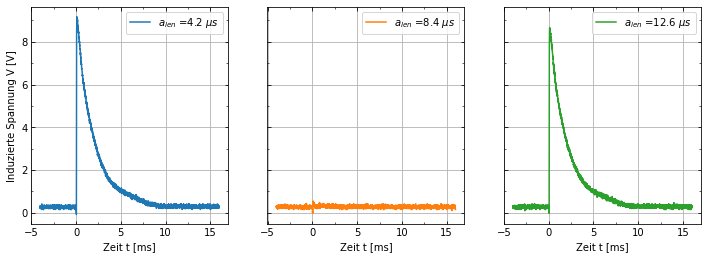

In [6]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
fig, axs = plt.subplots(1,3,figsize=(12,4), sharey=True)

for i in range(3):
    data.plot(x='time',y=labels[i], ax=axs[i], color=colors[i], label=f'$a_{{len}}$ ={selection[i].A} $\\mu s$')
    axs[i].set_xlabel("Zeit t [ms]")
    axs[i].set_ylabel("Induzierte Spannung V [V]")
    axs[i].grid()
    ticks_handle(axs[i], which='both')
fig.savefig('IMAGES/lmo_fid.png')

## T1 aus Periode

Daten von Tag 1
&gt; path = 'data_day_one'; meas = E
zu kleine Zeiten P

Daten von Tag 2
&gt; path = 'data_day_two', meas = K;

In [7]:
# Neuer Versuch
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "K")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove("time")
P1 = np.array([meas.P for meas in selection])
M1 = np.array([data[l].max() for l in labels])

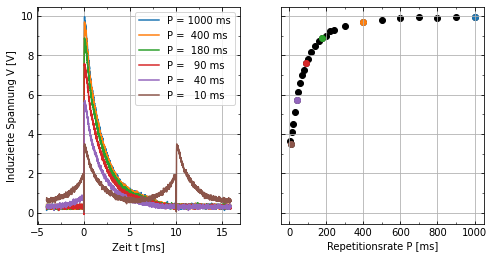

In [8]:
split=False
if not split:
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
else:
    fig1, (ax) = plt.subplots(figsize=(4, 4))
    fig2, (bx) = plt.subplots(figsize=(4, 4))

inds = [0, 6, 11, 16, 21, 25]
data.plot(x="time",y=[labels[i] for i in inds], ax=ax,
          label=[f'P = {P1[i]:4.0f} ms' for i in inds])
ax.set_xlabel("Zeit t [ms]")
ax.set_ylabel("Induzierte Spannung V [V]")
ax.legend()

bx.scatter(P1, M1, color='black')
for idx in inds:
    bx.scatter(P1[idx], M1[idx])
bx.set_xlabel("Repetitionsrate P [ms]")
bx.set_ylabel("Induzierte Spannung V [V]")
bx.set_ylim(*ax.get_ylim())

#bx.plot(P, res.best_fit)
#bx.hlines(M0, xmin=0, xmax=1000, color='gray',ls='--')
#bx.vlines(T1, ymin=0, ymax=10, color='gray',ls='--')
#print(f'{T1=} ms')

ax.grid()
bx.grid()
ticks_handle(ax, which='both')
ticks_handle(bx, which='both')

if not split:
    fig.savefig('IMAGES/lmo_t1_periode.png')
else:
    fig1.savefig('IMAGES/lmo_t1_periode_a.png')
    fig2.savefig('IMAGES/lmo_t1_periode_b.png')
plt.show()

## T1 aus Echo-Methode

Daten: Tag 1, meas == H, Tau ungeüngedner Bereich

Data day two: meas == L

In [9]:
path = 'data_day_two'
file_list = fo.load_file_list(path)
selection = (fo.select_files(file_list,'meas','L'))
data = fo.load_files(selection)
for d in data:
    d['time'] = d['time']*1000

idx = [d['signal'].idxmax() for d in data]
M2 = np.array([d.loc[i, 'signal'] for i,d in zip(idx, data)])
P2 = np.array([d.loc[i, 'time'] for i,d in zip(idx, data)])

In [10]:
M2[17] = 0.43
P2[17] = 36
ran = list(range(45))
ran.remove(34)
ran.remove(38)

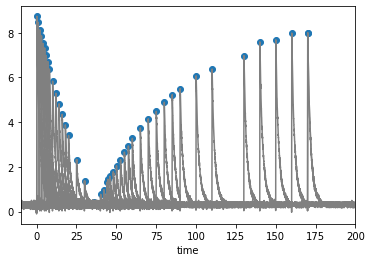

In [11]:
fig,ax = plt.subplots()
for i in ran:
    data[i].plot(x='time', y='signal', ax=ax,color='gray')
ax.set_xlim(-10, 200)

ax.scatter(P2[ran], M2[ran])
ax.legend().remove()

## Fit T1

In [12]:
# def t1func(t, M0, T1):
#     return M0*(1-np.exp(-t/T1))
# model = Model(t1func, nan_policy='omit')

In [13]:
def fit_t1(t, y, log=False):
    ''' clean function. '''
    def fitfunc(t, M0, T1):
        return M0*(1-np.exp(-t/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10)
    if log: print(res.fit_report())
    M0 = res.params['M0'].value
    T1 = res.params['T1'].value
    print(f'original:\n {M0=},\n {T1=}')
    return res

def fit_t1b(t, y, log=False):#
    ''' Fit function with constant y-offset'''
    def fitfunc(t, M0, T1,c):
        return M0*(1-np.exp(-(t)/T1))+c

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10,c=0)
    if log: print(res.fit_report())
        
    M0 = res.params['M0'].value
    T1 = res.params['T1'].value
    c = res.params['c'].value
    print(f'y-offset:\n {M0=},\n {T1=},\n {c=}')
    return res

def fit_t1c(t, y, log=False):
    ''' fitfunciton with timeoffsest'''
    def fitfunc(t, M0, T1,c):
        return M0*(1-np.exp(-(t+c)/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10,c=0)
    if log: print(res.fit_report())
        
    M0 = res.params['M0'].value
    T1 = res.params['T1'].value
    c = res.params['c'].value
    print(f't-offset:\n {M0=},\n {T1=},\n {c=}')
    return res


def fit_t1d(t, y,M0, log=False):
    ''' fit function with static M0'''
    def fitfunc(t, T1):
        return M0*(1-np.exp(-t/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, T1=10)
    if log: print(res.fit_report())
    #M0 = res.params['M0']
    T1 = res.params['T1'].value
    print(f'M0 const:\n {M0=},\n {T1=}')
    return res

In [14]:
# handle data from Echo
ran2 = [i for i in ran if i >= 17]
res2 = fit_t1(P2[ran2]-34,M2[ran2])
res2b = fit_t1b(P2[ran2],M2[ran2])
res2c = fit_t1c(P2[ran2],M2[ran2])

original:
 M0=8.96534354127904,
 T1=59.58939159997844
y-offset:
 M0=16.190857232554368,
 T1=57.46890612872692,
 c=-7.320190832265909
t-offset:
 M0=8.870666361051235,
 T1=57.4689053667857,
 c=-34.57885662134211


Betrachte die Oben ausgegebenen Parameter für den Fit der Echo-Daten: Ich halte hier den t-offset für die richtige Version. Da für den originalen Fit die 34 ms als schätzwert abgezogen werden. Beim Vergleich sind T1 für beide offset-Varianten gleich. M0 hat für toffset aber den sinvolleren Wert. Daher wäre das mein Favorit. Aber was ist mit den P-Variations-Daten?

In [15]:
# handle data from P
res1 = fit_t1(P1,M1)
res1b = fit_t1b(P1,M1)
res1c = fit_t1c(P1,M1)
res1d = fit_t1d(P1,M1, M0=9.8)

original:
 M0=9.36154480187681,
 T1=42.252219836006475
y-offset:
 M0=6.745144627293254,
 T1=85.19839275203833,
 c=3.079596785242552
t-offset:
 M0=9.824736480143182,
 T1=85.19797093690526,
 c=32.04122925315717
M0 const:
 M0=9.8,
 T1=48.85047827307426


Auch hier führen t und y offset jeweils zur gleichen Funktion. 85 ms ist dabei aber deutlich höher.
Die Originale Funktion fände ich passend, aber die sieht geplottet eher mieß aus (siehe nächste Zelle). 
Die vierte Variante ist ein Fit nur für T1 mit einem fest gesetzten Wert für M0 aus den Daten.
Das wäre etwas was ich garnicht schlecht finde. Dann kommen wir auf T1 = 48 ms, dass ist ja ähnlich zu 57 ms (zumindest in etwa)

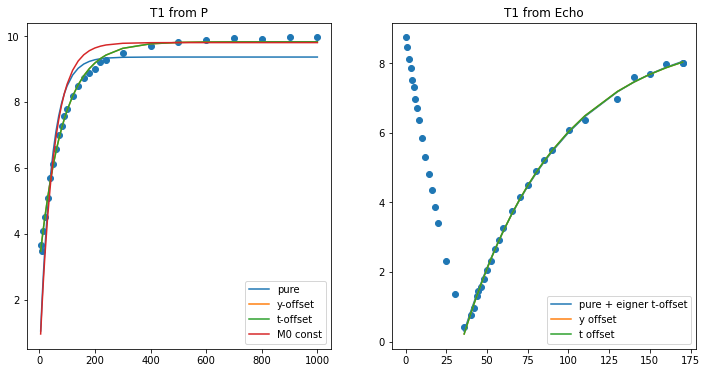

In [16]:
fig, (ax,bx) = plt.subplots(1,2, figsize=(12,6))
ax.scatter(P1,M1)
ax.plot(P1, res1.best_fit, label='pure')
ax.plot(P1, res1b.best_fit, label='y-offset')
ax.plot(P1, res1c.best_fit, label='t-offset')
ax.plot(P1, res1d.best_fit, label='M0 const')

ax.set_title('T1 from P')


bx.scatter(P2[ran], M2[ran])
bx.plot(P2[ran2], res2.best_fit, label='pure + eigner t-offset')
bx.plot(P2[ran2], res2b.best_fit, label = 'y offset')
bx.plot(P2[ran2], res2c.best_fit, label = 't offset')

bx.set_title('T1 from Echo')
ax.legend()
bx.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>